In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from itertools import product 
from datetime import datetime
import matplotlib.ticker as ticker
import statsmodels.api as sm
import patsy

In [3]:
data = pd.read_excel('BTC Price.xlsx',header=0, index_col=0)
data.index = pd.to_datetime(data.index)

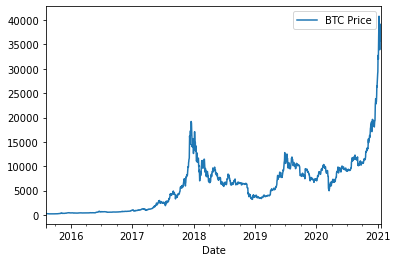

In [4]:
data.plot()

In [5]:
#  choose data from 2015-8-7 to 2020-9-30 to make a prediction 
btc_train = data.loc['2015-08-07':'2020-9-30']

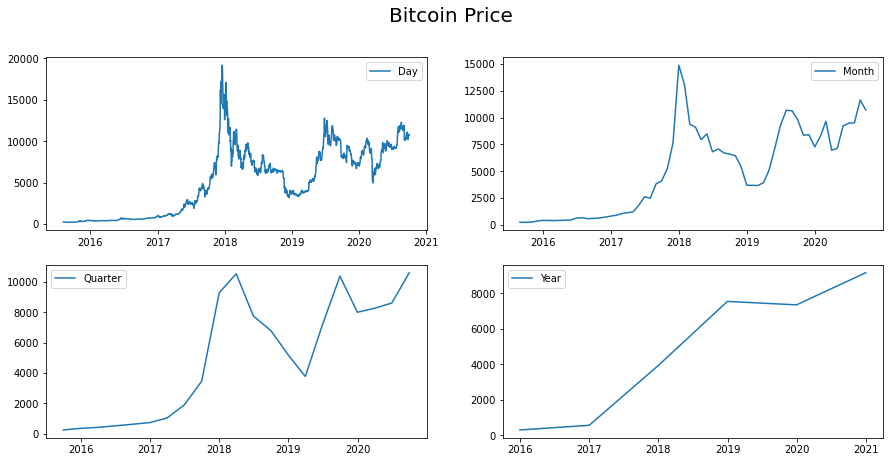

In [6]:
# view the difference between DAY, MONTH, QUARTER and YEAR data
df_month = btc_train.resample('M').mean()
df_Q = btc_train.resample('Q-DEC').mean()
df_year = btc_train.resample('A-DEC').mean()

fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin Price', fontsize=20)
plt.subplot(221)
plt.plot(btc_train['BTC Price'], '-', label='Day')
plt.legend()
plt.subplot(222)
plt.plot(df_month['BTC Price'], '-', label='Month')
plt.legend()
plt.subplot(223)
plt.plot(df_Q['BTC Price'], '-', label='Quarter')
plt.legend()
plt.subplot(224)
plt.plot(df_year['BTC Price'], '-', label='Year')
plt.legend()
plt.show()

In [7]:
# test stationarity
from statsmodels.tsa.stattools import adfuller

In [8]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

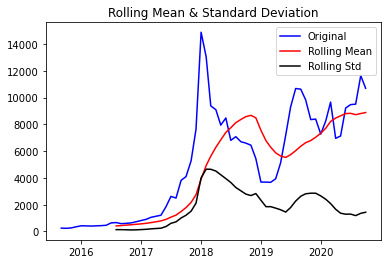

Results of Dickey-Fuller Test:
Test Statistic                 -1.652361
p-value                         0.455810
#Lags Used                      1.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64


In [9]:
test_stationarity(df_month)

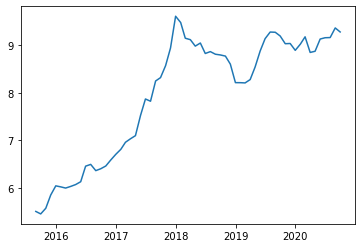

In [10]:
# log transformation 
data_log = df_month.apply(np.log)
plt.plot(data_log)

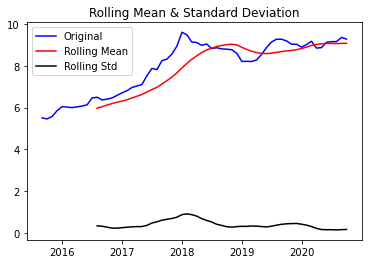

Results of Dickey-Fuller Test:
Test Statistic                 -1.869561
p-value                         0.346513
#Lags Used                      1.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64


In [11]:
test_stationarity(data_log)

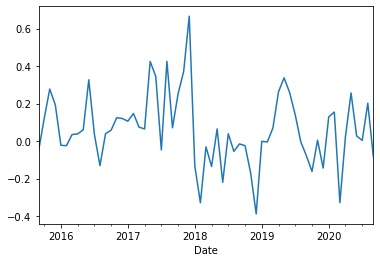

In [12]:
# differencing 
diff1 = pd.Series(data_log['BTC Price']).diff(1)[1:] 
diff1.plot()

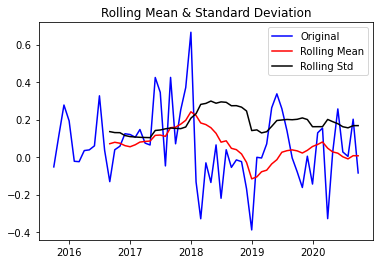

Results of Dickey-Fuller Test:
Test Statistic                 -5.629975
p-value                         0.000001
#Lags Used                      0.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64


In [13]:
test_stationarity(diff1)

In [14]:
diff1 = pd.DataFrame(diff1)

Wrong Parameter: (1, 2)
Best Model:                                ARMA Model Results                              
Dep. Variable:              BTC Price   No. Observations:                   61
Model:                     ARMA(0, 1)   Log Likelihood                  17.337
Method:                       css-mle   S.D. of innovations              0.182
Date:                Wed, 27 Jan 2021   AIC                            -28.674
Time:                        21:56:30   BIC                            -22.341
Sample:                    09-30-2015   HQIC                           -26.192
                         - 09-30-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0603      0.030      1.981      0.048       0.001       0.120
ma.L1.BTC Price     0.3103      0.125      2.491      0.013       0.066       0

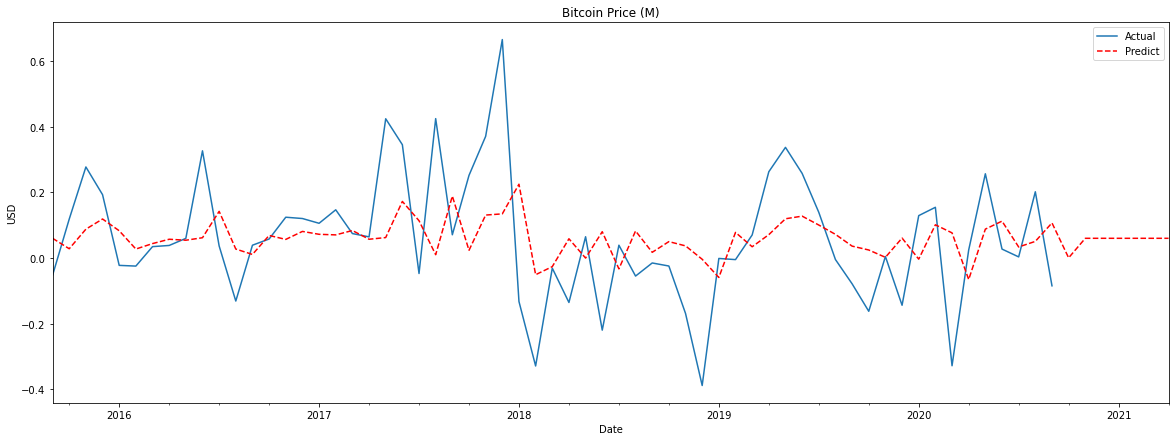

In [15]:
# predict
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)
# find least best_aic 
results = []
best_aic = float("inf") 
for param in parameters_list:
    try:
        model = ARMA(diff1['BTC Price'],order=(param[0], param[1])).fit()
    except ValueError:
        print('Wrong Parameter:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# best model
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print('Best Model: ', best_model.summary())

# Bitoin prediction 
df_month2 = diff1

# prdict seven months after 2020-09
date_list = [datetime(2020, 10, 31), datetime(2020, 11, 30),datetime(2020, 12, 31),
             datetime(2021, 1, 31),datetime(2021, 2, 28),datetime(2021, 3, 31),datetime(2021, 4, 30)]
future = pd.DataFrame(index=date_list, columns= diff1.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start='2015-9', end='2021-4')

# result
plt.figure(figsize=(20,7))
df_month2['BTC Price'].plot(label='Actual')
df_month2['forecast'].plot(color='r', ls='--', label='Predict')
plt.legend()
plt.title('Bitcoin Price (M)')
plt.xlabel('Date')
plt.ylabel('USD')
plt.show()

In [16]:
# take back to oringinal scale
series = pd.Series(data_log.iloc[0])
series.index = [data_log.index[0]]

In [17]:
series 

2015-08-31    5.507333
Name: 2015-08-31 00:00:00, dtype: float64

In [18]:
predict_log = series.append(df_month2['forecast']).cumsum()

In [19]:
log_recover = np.exp(predict_log)
log_recover.dropna(inplace = True)

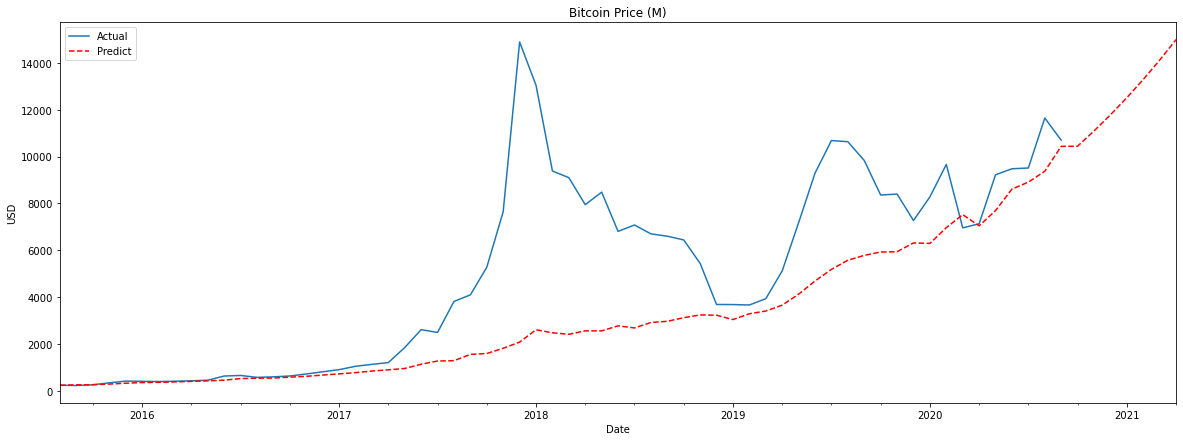

In [20]:
plt.figure(figsize=(20,7))
df_month['BTC Price'].plot(label='Actual')
log_recover.plot(color='r', ls='--', label='Predict')
plt.legend()
plt.title('Bitcoin Price (M)')
plt.xlabel('Date')
plt.ylabel('USD')
plt.show()

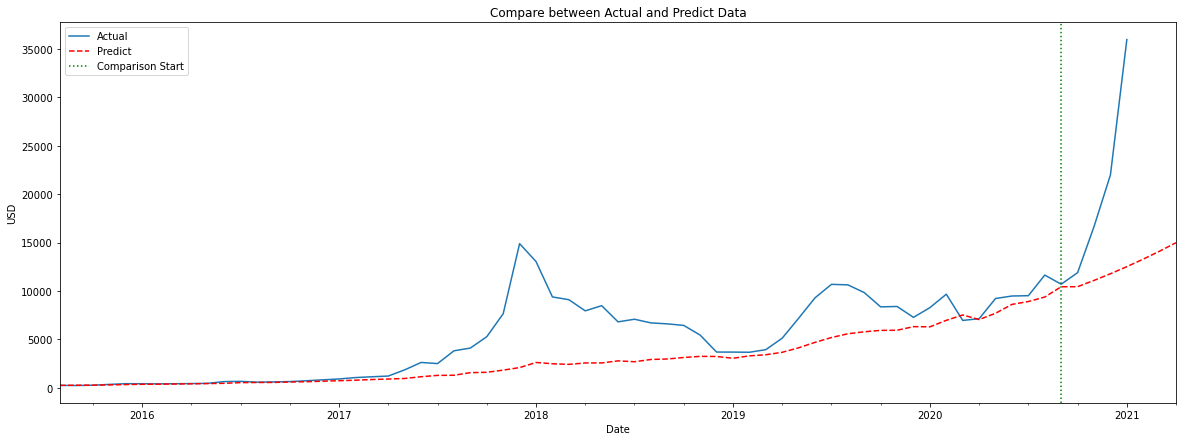

In [21]:
# compare with actual data after 09/2020
ac_month = data.resample('M').mean()
x = ('2020-9-30')

plt.figure(figsize=(20,7))
ac_month['BTC Price'].plot(label='Actual',markersize = 12)
log_recover.plot(color='r', ls='--', label='Predict',markersize = 12)
plt.axvline(x,color = 'g',linestyle = ':',label = 'Comparison Start')
plt.legend()
plt.title('Compare between Actual and Predict Data')
plt.xlabel('Date')
plt.ylabel('USD')

plt.show()